In [1]:
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from shapely.geometry import box
from sqlalchemy import text

plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Terrestrial inputs

## Notebook 01: Water discharge

**Run this notebook on one of the Hub's "high memory" machines (48 GB of RAM or greater).**

This notebook identifies river outlets to the coast within an area of interest and estimates flow time series for each outlet.

## 1. User inputs

We use the ELVIS river network to represent streams in Norway. The ELVIS dataset is initially filtered to only consider streams with a Strahler order greater than or equal to `min_order`. To identify outlet locations, "Havflate" polygons from Kartverket's `ArealdekkeFlate` layer in the N50 dataset are buffered by `buffer` metres and then intersected with the ELVIS streams. This gives one point near the outlet for every stream of interest.

Catchment boundaries are derived for each outlet point and daily flow data estimated for each catchment using two methods:

 1. Area-scaling the vassdragsområde-level flow data provided each year by Stein Beldring for TEOTIL/Elveovervåkingsprogrammet, and
    
 2. Summing runoff data for upstream grid cells using parameter `gwb_q` from the [GTS API](https://api.nve.no/doc/gridtimeseries-data-gts/#introduksjon).

**Note:** The dataset from Stein uses a spatially-distributed version of HBV implemented in C++. These results are the most reliable, but they are delivered annually and are only available aggregated to vassdragsområde level. The GTS API provides similar output from a slightly different version of the model (implemented in Fortran). Stein recommends using output from the C++ version where possible, but the Fortran version runs operationally and results can be queried at 1 km resolution for any area, making it more flexible. The two approaches are compared at the end of this notebook.

In [3]:
# Projected CRS to work in
epsg = 25833

# Define area of interest. Provide lower-left corner of bounding box
# in the units of the CRS chosen above. Then provide width and height in km
xmin, ymin = 635000, 7700000
width_km, height_km = 200, 200

# Buffer to apply to coastline to ensure rivers meet coast.
# In units of the CRS chosen above
buffer = 200

# Smallest ELVIS stream order to keep
min_order = 3

# NVE flow series to use for data from Stein. Year of data supply
nve_data_year = 2024

# Period of interest for flow data
st_yr, end_yr = 2017, 2023

# Output time resolution for discharge series ('daily', 'monthly', 'annual').
# NVE's raw model output is daily. Monthly and annual series are calculated by averaging
t_res = "daily"

# Smallest catchments for delineation. Used to snap outlet co-ordinates to the flow
# accumulation grid to improve catchment delineation
min_size_km2 = 0.5

# Folder to save output
output_dir = "/home/jovyan/shared/common/JES/terrestrial_fluxes"

In [4]:
# Validate inputs
if t_res not in ["daily", "monthly", "annual"]:
    raise ValueError("'t_res' must be one of ['daily', 'monthly', 'annual'].")

# Frequency codes for resampling
resamp_dict = {"daily": "D", "monthly": "MS", "annual": "YS"}

# Create folders for results
for dir_name in ["shp", "csv"]:
    dir_path = os.path.join(output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

## 2. Identify river outlets

In [5]:
# Create bounding box
xmax = xmin + (width_km * 1000)
ymax = ymin + (height_km * 1000)
bbox = box(xmin, ymin, xmax, ymax)

# Read rivers
riv_gdf = (
    nivapy.da.read_postgis("physical", "norway_nve_elvis_river_network_line", eng)
    .query("elveorden >= @min_order")
    .to_crs(f"epsg:{epsg}")
    .clip(bbox)
)

# Read N50 surface cover and get just the sea polys
sea_gdf = (
    gpd.read_file(
        r"/home/jovyan/shared/common/JES/n50_kartdata/N50_Kartdata.gdb",
        layer="N50_ArealdekkeFlate",
    )
    .query("OBJTYPE == 'Havflate'")
    .to_crs(f"epsg:{epsg}")
    .clip(bbox)
)

# Dissolve sea polys and buffer
sea_gdf["dissolve"] = 1
sea_gdf = sea_gdf.dissolve(by="dissolve")
sea_gdf["geometry"] = sea_gdf["geometry"].buffer(buffer)

# Calculate intersections
outlet_gdf = sea_gdf.set_geometry(sea_gdf.boundary).overlay(
    riv_gdf, keep_geom_type=False
)
outlet_gdf = outlet_gdf.explode(index_parts=True).reset_index(drop=True)
outlet_gdf = outlet_gdf.drop_duplicates(subset="elvid")
outlet_gdf["easting"] = outlet_gdf.geometry.x
outlet_gdf["northing"] = outlet_gdf.geometry.y
outlet_df = outlet_gdf[["elvid", "vassdragnr", "easting", "northing"]]

print(
    f"{len(outlet_df)} outlets for streams of order {min_order} or greater identified within the area of interest."
)

357 outlets for streams of order 3 or greater identified within the area of interest.


## 3. Catchment boundaries

Calculate catchment boundaries for each outlet.

In [6]:
# Catchment boundaries and areas
cat_gdf = nivapy.spatial.derive_watershed_boundaries(
    outlet_df,
    id_col="elvid",
    xcol="easting",
    ycol="northing",
    crs=f"epsg:{epsg}",
    min_size_km2=min_size_km2,
    dem_res_m=40,
    reproject=True,
)
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6

Connection successful.


Looping over vassdragsområder:   0%|          | 0/21 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 197:   0%|          | 0/19 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 198:   0%|          | 0/34 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 199:   0%|          | 0/12 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 200:   0%|          | 0/19 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 201:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 202:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 203:   0%|          | 0/18 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 204:   0%|          | 0/17 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 205:   0%|          | 0/5 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 206:   0%|          | 0/18 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 207:   0%|          | 0/12 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 208:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 209:   0%|          | 0/17 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 210:   0%|          | 0/15 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 211:   0%|          | 0/30 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 212:   0%|          | 0/17 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 213:   0%|          | 0/18 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 214:   0%|          | 0/9 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 215:   0%|          | 0/25 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 216:   0%|          | 0/41 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 217:   0%|          | 0/16 [00:00<?, ?it/s]

<Axes: >

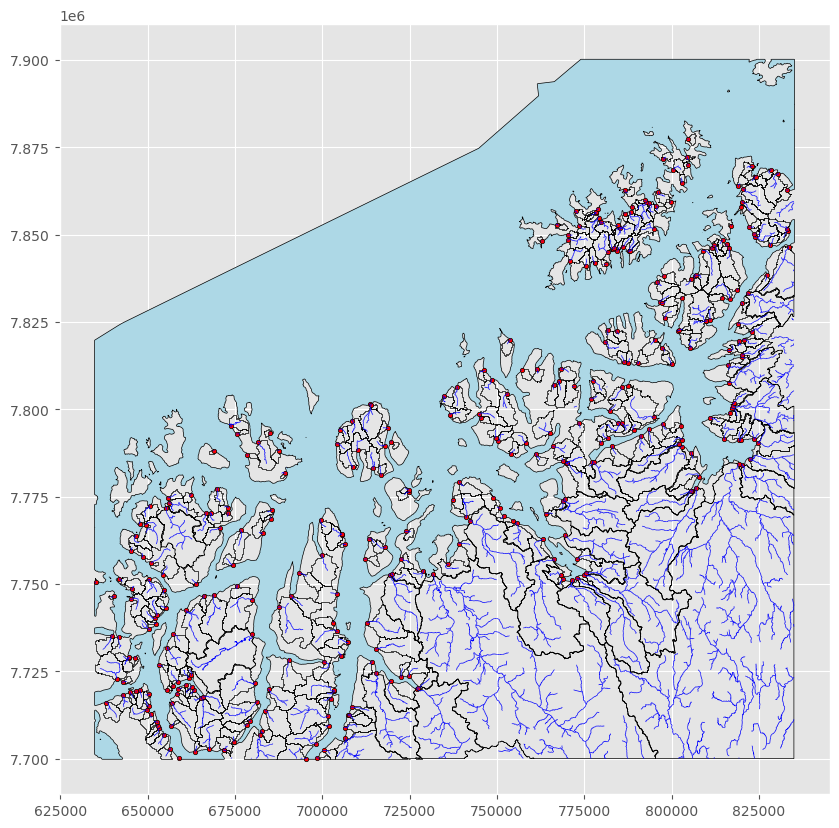

In [7]:
# Plot
ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5, figsize=(10, 10))
cat_gdf.clip(bbox).plot(ax=ax, lw=0.5, edgecolor="k", facecolor="none")
riv_gdf.plot(ax=ax, lw=0.5, edgecolor="blue")
outlet_gdf.plot(ax=ax, marker="o", color="red", edgecolor="black", markersize=10)

In [8]:
# Save shapefiles
sea_gdf.to_file(os.path.join(output_dir, "shp", "sea.shp"))
riv_gdf.to_file(os.path.join(output_dir, "shp", "rivers.shp"))
cat_gdf.to_file(os.path.join(output_dir, "shp", "catchments.shp"))
outlet_gdf.to_file(os.path.join(output_dir, "shp", "outlets.shp"))

## 4. Estimate flows

### 4.1. Area-scaling from vassdragsområde data

Each year, Stein provides daily flow time series from 1990 to the present for each vassdragsområde. A simple way to estimate flows for each catchment of interest is therefore to area-scale the vassdragsområde-level data to match the target catchments. This will probably work OK for small coastal vassdragsområder comprising many small catchments. It should also work for the outflows of major rivers. However, it probably won't work well for small coastal catchments within larger vassdragsområder, because the vassdragsområde-level totals will not be representative of local runoff near to the coast.

In [9]:
# Get vassom properties
vassom_gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)

# Loop over catchments
df_list = []
for idx, row in cat_gdf.iterrows():
    elvid = row["elvid"]

    # Identify vassom for catchment
    vassom = row["vassdragnr"].split(".")[0]

    # Get area scale factor
    cat_area_km2 = row["area_km2"]
    vassom_area_km2 = vassom_gdf.query("vassdragsomradenr == @vassom")[
        "arealland_km2"
    ].iloc[0]
    assert cat_area_km2 < vassom_area_km2
    area_fac = cat_area_km2 / vassom_area_km2

    # Get NVE data for vassom
    sql = text(
        "SELECT * FROM teotil3.nve_hbv_discharge "
        "WHERE data_supply_year = :nve_data_year "
        "AND vassom = :vassom"
    )
    q_df = pd.read_sql(
        sql, eng, params={"nve_data_year": nve_data_year, "vassom": vassom}
    )[["date", "flow_m3/s"]].query(f"'{st_yr}-01-01' <= date <= '{end_yr}-12-31'")

    # Scale flows
    q_df["flow_m3/s"] = area_fac * q_df["flow_m3/s"]

    # Resample to output frequency
    q_df = q_df.set_index("date").resample(resamp_dict[t_res]).mean().reset_index()

    q_df["elvid"] = elvid

    df_list.append(q_df)

q_df = pd.concat(df_list, axis="rows")
q_df = q_df[["elvid", "date", "flow_m3/s"]]

# Save
outlet_csv_path = os.path.join(output_dir, "csv", "outlets.csv")
outlet_df.to_csv(outlet_csv_path, index=False)

flow_csv_path = os.path.join(output_dir, "csv", "flows_scale_vassoms.csv")
q_df.to_csv(flow_csv_path, index=False)

q_df.head()

,elvid,date,flow_m3/s
0,197-15-1,2017-01-01,1.197417
1,197-15-1,2017-01-02,0.939704
2,197-15-1,2017-01-03,0.844680
3,197-15-1,2017-01-04,0.786321
4,197-15-1,2017-01-05,0.736404


### 4.2. Data from GTS API

An alternative approach is to use the GTS API to download simulated daily runoff for all 1 km grid cells within each target catchment. Summing the runoff gives an estimate of the outlet discharge.

In [10]:
%%capture
# Loop over catchments of interest. GTS API occasionally times-out, so the code
# below includes a hacky solution to retry up to 'n_retries' times when this occurs.
# TO DO: Update nivapy.da.get_nve_gts_api_aggregated_time_series to properly handle
# timeout errors, then streamline this code.
n_retries = 10
df_list = []
for idx in range(len(cat_gdf)):
    retry_count = 0
    while retry_count < n_retries:
        try:
            gwb_df = nivapy.da.get_nve_gts_api_aggregated_time_series(
                cat_gdf.iloc[[idx]],
                ["gwb_q"],
                f"{st_yr}-01-01",
                f"{end_yr}-12-31",
                id_col="elvid",
            )
            break
        except ValueError:
            # No data for catchment. Move to next iteration
            gwb_df = None
            break
        except Exception as e:
            # Probably a TimeoutError. Retry
            retry_count += 1
            if retry_count >= n_retries:
                gwb_df = None
                break

    if gwb_df is None:
        continue

    cat_area = cat_gdf["area_km2"].iloc[idx]
    gwb_df["flow_m3/s"] = 1e6 * gwb_df["value_mean"] * cat_area / (1000 * 60 * 60 * 24)
    gwb_df = gwb_df[["elvid", "datetime", "flow_m3/s"]]
    gwb_df.columns = ["elvid", "date", "flow_m3/s"]

    # Resample to output frequency
    gwb_df = gwb_df.set_index("date").resample(resamp_dict[t_res]).mean().reset_index()
    gwb_df = gwb_df[["elvid", "date", "flow_m3/s"]]

    df_list.append(gwb_df)

gwb_df = pd.concat(df_list, axis="rows")

# Save
flow_csv_path = os.path.join(output_dir, "csv", "flows_gts-api.csv")
gwb_df.to_csv(flow_csv_path, index=False)

gwb_df.head()

### 4.3. Compare

Compare flows estimated using the two methods.

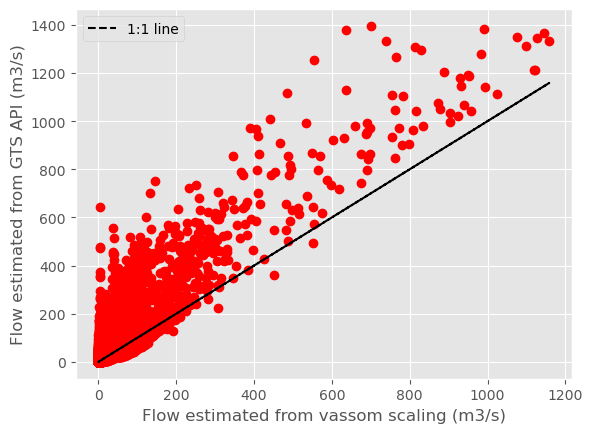

In [11]:
# Combine datasets
df = pd.merge(
    q_df,
    gwb_df,
    how="inner",
    on=["elvid", "date"],
    suffixes=["_scale-vassoms", "_gts-api"],
)
plt.plot(df["flow_m3/s_scale-vassoms"], df["flow_m3/s_gts-api"], "ro")
plt.plot(
    df["flow_m3/s_scale-vassoms"],
    df["flow_m3/s_scale-vassoms"],
    "k--",
    label="1:1 line",
)
plt.xlabel("Flow estimated from vassom scaling (m3/s)")
plt.ylabel("Flow estimated from GTS API (m3/s)")
plt.legend(loc="upper left")

The code above estimates flows for potentially hundreds of catchments. The cell below picks `n_plot` catchments from these at random and shows flow time series for comparison.

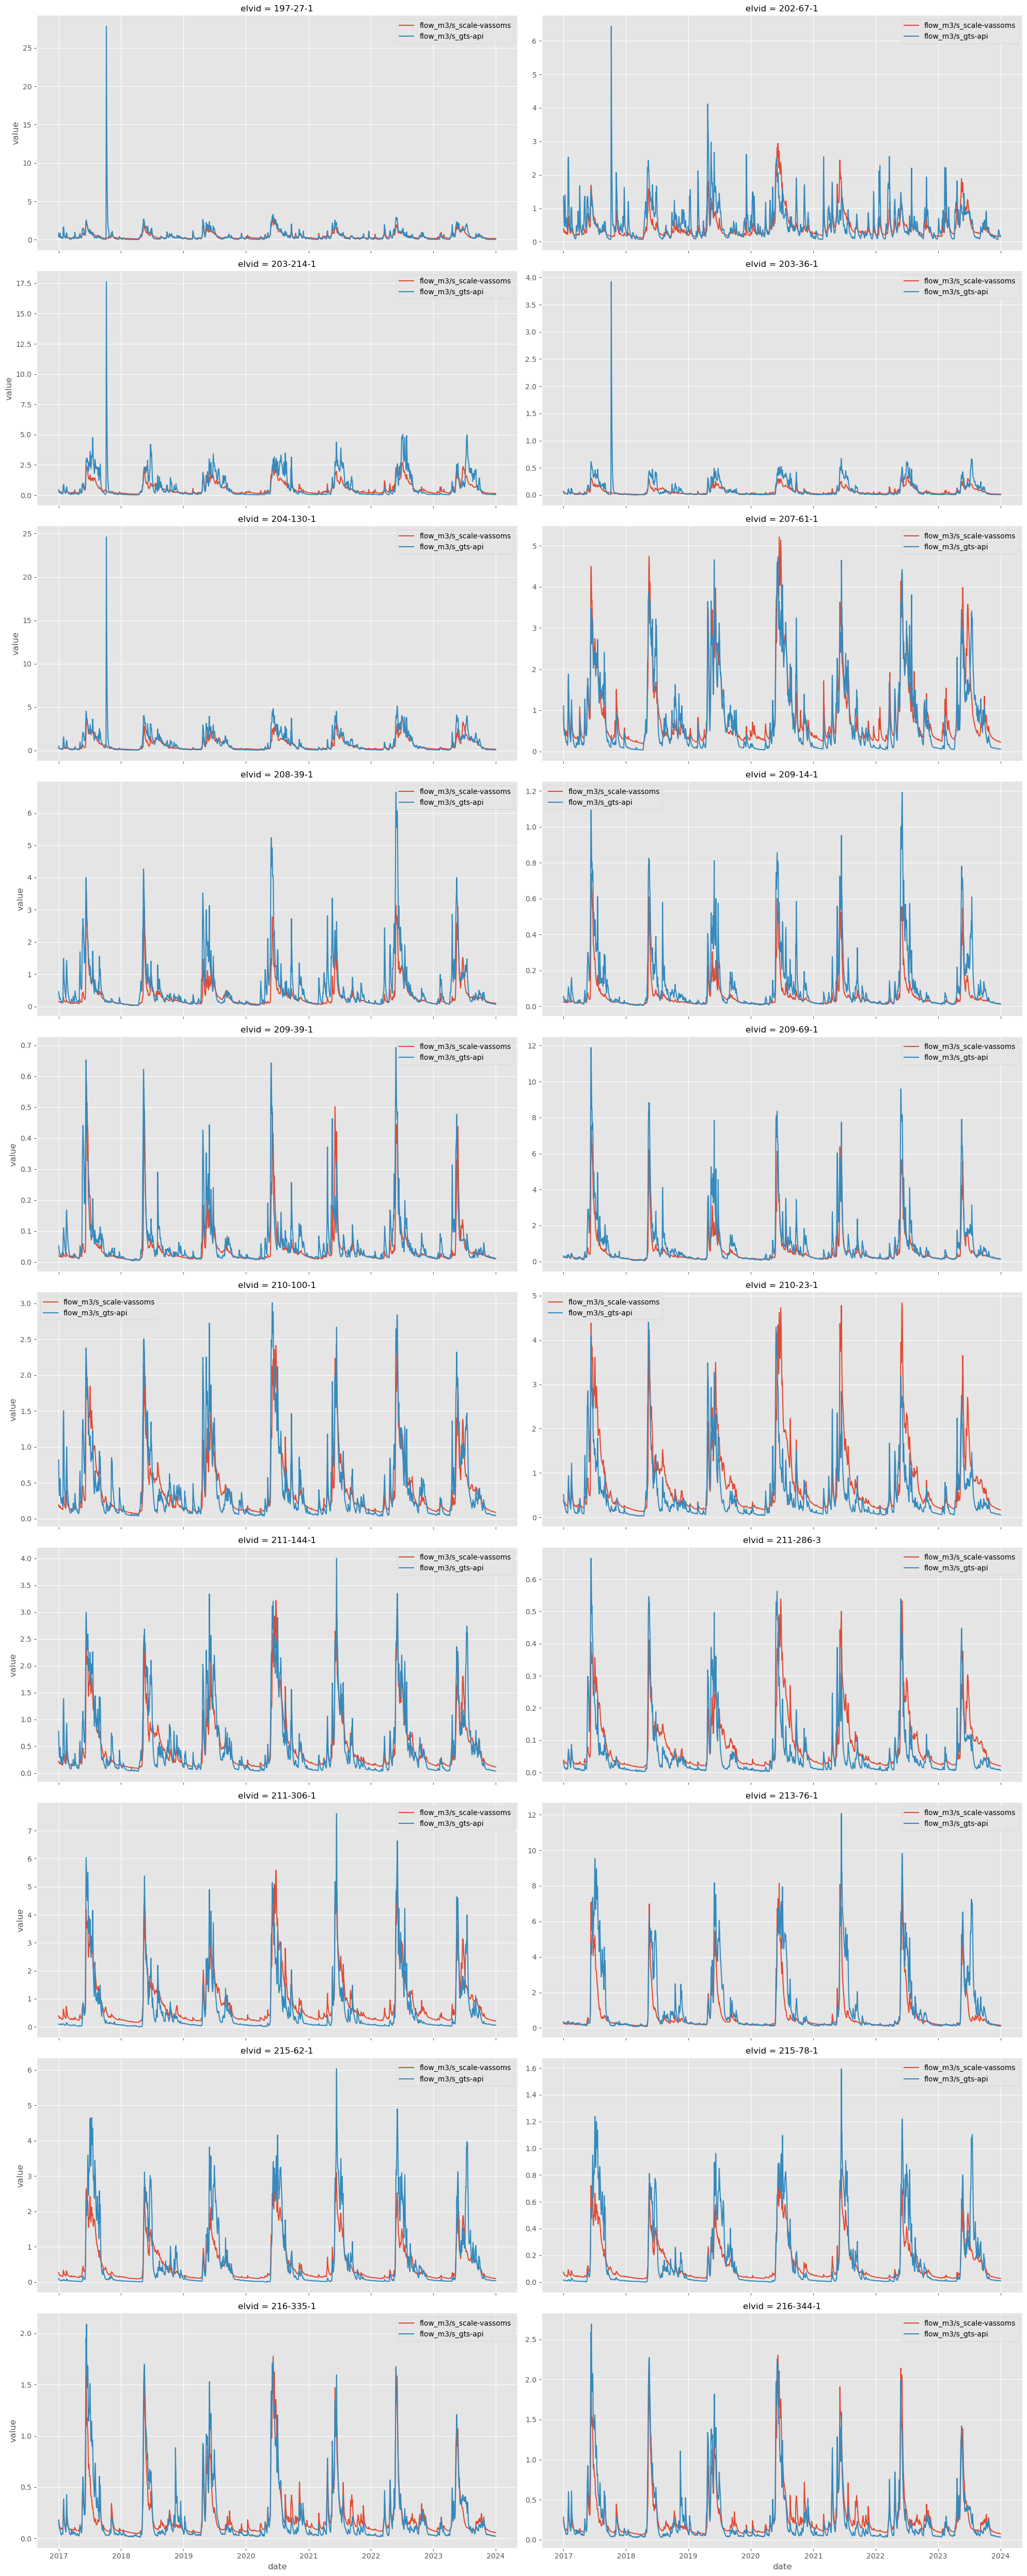

In [20]:
# Select n_plot sites at random for visualisation
n_plot = 20
df_long = df.melt(id_vars=["elvid", "date"], var_name="par")
elvids = df_long["elvid"].drop_duplicates().sample(n=n_plot, random_state=1)
df_filtered = df_long[df_long["elvid"].isin(elvids)]

# Plot
g = sn.relplot(
    data=df_filtered,
    x="date",
    y="value",
    hue="par",
    col="elvid",
    col_wrap=2,
    kind="line",
    facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    aspect=2,
)

handles, labels = g.axes.flat[0].get_legend_handles_labels()
for ax in g.axes.flat:
    ax.legend(handles, labels)

## 5. Comparison to observations

**To do:** Identify some monitoring stations near the coast within the area of interest and compare discharges estimated using the two methods above to measured flows.